In [1]:
%matplotlib inline
from keras.models import Sequential, load_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint,History,EarlyStopping,LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, Adadelta, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# For adding new activation function
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
print(data.shape)

(60000, 785)


In [3]:
test_data = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
print(test_data.shape)

(5000, 785)


# Divide data into training and validation sets

In [4]:
train = data[:]
val = data[55000:]
train_label = np.float32(train.label)
val_label = np.float32(val.label)
train_image = np.float32(train[train.columns[1:]])
val_image = np.float32(val[val.columns[1:]])
test_image = np.float32(test_data[test_data.columns[1:]])
print('train shape: %s'%str(train.shape))
print('val shape: %s'%str(val.shape))
print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))
print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))
print('test_image shape: %s'%str(test_image.shape))

train shape: (60000, 785)
val shape: (5000, 785)
train_label shape: (60000,)
val_label shape: (5000,)
train_image shape: (60000, 784)
val_image shape: (5000, 784)
test_image shape: (5000, 784)


# Data enhancement

In [5]:
datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.24,
    height_shift_range=0.24,
    shear_range = 0.1,
    zoom_range = 0.24,
    horizontal_flip = False)

# One-hot encode

In [6]:
# one-hot coding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False,categories='auto')
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
# transform
train_label = train_label.reshape(-1,1)
val_label = val_label.reshape(-1,1)

train_label = encoder.transform(train_label)
val_label = encoder.transform(val_label)

print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))

train_label shape: (60000, 10)
val_label shape: (5000, 10)


# Image transform

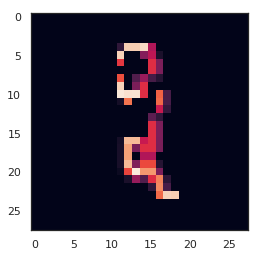

(784,)
train_image shape: (60000, 28, 28, 1)
train_image shape: (60000, 28, 28, 1)
val_image shape: (5000, 28, 28, 1)


In [7]:
plt.imshow(train_image[13].reshape(28,28))
plt.show()
print(train_image[13].shape)

train_image = train_image/255.0
val_image = val_image/255.0
test_image = test_image/255.0

train_image = train_image.reshape(train_image.shape[0],28,28,1)
val_image = val_image.reshape(val_image.shape[0],28,28,1)
test_image = test_image.reshape(test_image.shape[0],28,28,1)
print('train_image shape: %s'%str(train_image.shape))

print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))

# Building the model

In [8]:
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})


In [9]:
model = Sequential()
get_custom_objects().update({'swish': Activation(swish )})
model.add(Conv2D(64, kernel_size= (3,3), input_shape=(28, 28, 1),padding='same'))

model.add(BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='swish'))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, kernel_size =(3,3),padding='same', activation='swish'))
model.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128,(3,3), padding='same', activation='swish' ))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(256, kernel_size = (3,3), padding='same', activation='swish'))
model.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size= (3,3) ,padding='same', activation='swish'))
model.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)       

In [10]:
BATCH_SIZE = 2048
EPOCHS = 75

# Training

In [11]:
initial_learningrate= 2e-3


def lr_decay(epoch):#lrv
    return initial_learningrate * 0.96 ** epoch

In [12]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=8)
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.2)

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=initial_learningrate),
              metrics=['accuracy'])


history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=BATCH_SIZE),
    epochs = EPOCHS,validation_data = (val_image,val_label),
    callbacks=[LearningRateScheduler(lr_decay)],
      verbose=2)

Epoch 1/75
 - 27s - loss: 1.2196 - accuracy: 0.5865 - val_loss: 1.7134 - val_accuracy: 0.7264
Epoch 2/75
 - 20s - loss: 0.2446 - accuracy: 0.9217 - val_loss: 1.3109 - val_accuracy: 0.8622
Epoch 3/75
 - 20s - loss: 0.1447 - accuracy: 0.9537 - val_loss: 1.0145 - val_accuracy: 0.9724
Epoch 4/75
 - 21s - loss: 0.0887 - accuracy: 0.9725 - val_loss: 0.7031 - val_accuracy: 0.8904
Epoch 5/75
 - 21s - loss: 0.0769 - accuracy: 0.9759 - val_loss: 0.3363 - val_accuracy: 0.9950
Epoch 6/75
 - 20s - loss: 0.0626 - accuracy: 0.9795 - val_loss: 0.2590 - val_accuracy: 0.9546
Epoch 7/75
 - 20s - loss: 0.0525 - accuracy: 0.9832 - val_loss: 0.1710 - val_accuracy: 0.9962
Epoch 8/75
 - 21s - loss: 0.0483 - accuracy: 0.9844 - val_loss: 0.1627 - val_accuracy: 0.9384
Epoch 9/75
 - 21s - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0559 - val_accuracy: 0.9950
Epoch 10/75
 - 20s - loss: 0.0408 - accuracy: 0.9870 - val_loss: 0.0391 - val_accuracy: 0.9956
Epoch 11/75
 - 21s - loss: 0.0373 - accuracy: 0.9881 - val_

# Visualization

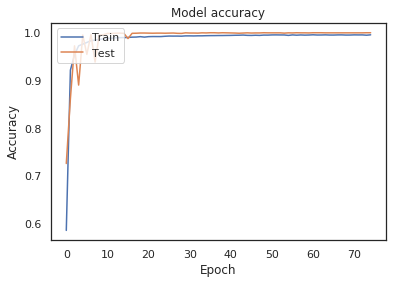

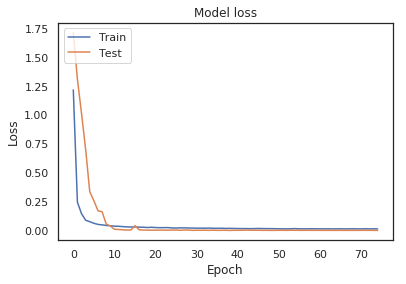

In [14]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
test_label = model.predict(test_image)
# label = np.argmax(label_hot,1)
# id_ = np.arange(0,label.shape[0])

In [16]:
label_hot = model.predict(test_image)
label = np.argmax(label_hot,1)
id_ = np.arange(0,label.shape[0])

In [17]:
sim = pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
print(sim.head(10))

   id  label
0   0      5
1   1      5
2   2      5
3   3      5
4   4      5
5   5      5
6   6      5
7   7      5
8   8      5
9   9      5


In [18]:
save = pd.DataFrame({'id':id_,'label':label})
print(save.head(10))
save.to_csv('submission.csv',index=False)

   id  label
0   0      3
1   1      0
2   2      2
3   3      6
4   4      7
5   5      7
6   6      1
7   7      9
8   8      3
9   9      4
